In [1]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

### Load data

In [3]:
dataset = pd.read_parquet("Datasets/train_pairs.parquet")
etl = pd.read_parquet("Datasets/train_data.parquet")

In [4]:
dataset.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [5]:
dataset["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

In [6]:
etl.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


Get raw data for each variantid.

In [10]:
tmp = etl['pic_embeddings_resnet_v1'].values
tmp[1]

array([array([ 0.26863545, -0.3130674 ,  0.29023397,  0.07397822,  0.13181262,
               0.10270227,  0.34185737, -0.272934  ,  1.1131566 , -1.1758841 ,
              -0.29369342, -0.07741779, -0.5371096 , -0.35637388,  0.5276637 ,
              -0.45687738, -0.21378133,  1.5331167 , -0.89128953,  0.48118243,
              -0.84258896,  0.4243123 ,  0.09662217, -0.39909384, -0.1556411 ,
              -0.5369617 , -0.42900747, -0.6742888 ,  0.83070225, -1.1620623 ,
               0.18242283, -0.7076701 ,  1.1039854 ,  0.43214688,  0.1410865 ,
               0.0174003 , -0.54143184, -1.3481662 , -1.5270164 , -0.6511549 ,
               0.60594976, -0.47410226, -0.02414984, -0.1560706 ,  0.0728327 ,
              -0.15040806, -0.70390433, -0.76463884,  0.9695078 ,  0.05226621,
               1.1919931 ,  0.13180336, -0.01353153, -1.0888747 , -0.71035343,
              -0.31424844, -0.4653632 , -0.23315454,  0.45585275, -1.2964255 ,
               0.62327254, -1.3632559 ,  0.20280471,

In [11]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [12]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,...","{""Электробезопасность"":[""Заземление""],""Длина к..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.43180764, -0.49580905, -0.5062628, -0.130...","[-0.5425725, 0.6415736, 0.51481575, -0.5687392...","{""Макс. нагрузка, Вт"":[""3500""],""Стандарт защит..."


Features functions.

In [8]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features


In [9]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [10]:
features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

# btw try to add distances between main pic embs

In [11]:
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

# try to use your favorite NLP model

In [12]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()

Let's find good cat size threshold

In [13]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
        
cntr

10765

10k for "rest" cats probably is good

In [14]:
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

Choose features

In [15]:
feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
         "euclidean_name_bert_dist", "cosine_name_bert_dist"]

Split dataset

In [16]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)


train_pool = Pool(
    data=X_train[feats],
    label=y_train,
)
eval_pool = Pool(
    data=X_val[feats],
    label=y_val,
)

Train model

In [17]:
model = CatBoostClassifier()

model.fit(
    train_pool,
    eval_set=eval_pool,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)
model.save_model(f"./models/baseline.cbm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.123728
0:	learn: 0.6776664	test: 0.6769780	best: 0.6769780 (0)	total: 168ms	remaining: 2m 47s


100:	learn: 0.5912099	test: 0.5880045	best: 0.5880045 (100)	total: 1.58s	remaining: 14s
200:	learn: 0.5826774	test: 0.5810349	best: 0.5810349 (200)	total: 2.93s	remaining: 11.6s
300:	learn: 0.5775730	test: 0.5779803	best: 0.5779803 (300)	total: 4.27s	remaining: 9.92s
400:	learn: 0.5737689	test: 0.5765949	best: 0.5765949 (400)	total: 5.62s	remaining: 8.39s
500:	learn: 0.5705921	test: 0.5753714	best: 0.5753714 (500)	total: 6.98s	remaining: 6.95s
600:	learn: 0.5676650	test: 0.5743284	best: 0.5743270 (598)	total: 8.32s	remaining: 5.52s
700:	learn: 0.5651892	test: 0.5737334	best: 0.5737208 (699)	total: 9.63s	remaining: 4.11s
800:	learn: 0.5627961	test: 0.5730553	best: 0.5730407 (798)	total: 11s	remaining: 2.72s
900:	learn: 0.5604663	test: 0.5723963	best: 0.5723954 (899)	total: 12.3s	remaining: 1.35s
999:	learn: 0.5583952	test: 0.5722274	best: 0.5721930 (993)	total: 13.6s	remaining: 0us

bestTest = 0.5721929863
bestIteration = 993

Shrink model to first 994 iterations.


CatBoostError: 

### Metric

In [25]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)
    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)

In [26]:
X_test["scores"] = model.predict_proba(X_test[feats])[:, 1]

In [27]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)
pr_auc_macro_metr

0.2632904963255657

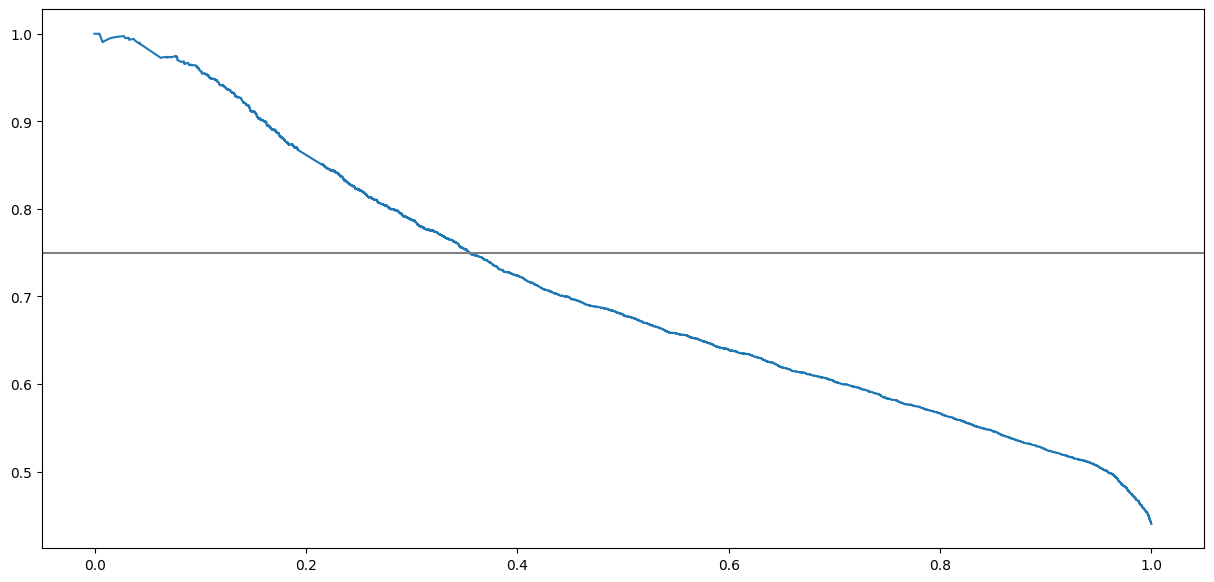

In [28]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

### Submission

In [35]:
test_pairs = pd.read_parquet("hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet")
test_etl = pd.read_parquet("hackathon_files_for_participants_ozon/test_data.parquet")

Generate the same features as for train

In [36]:
test_features = (
    test_pairs
    .merge(
        test_etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        test_etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [37]:
test_features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

test_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    test_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

In [38]:
test_features["cat3"] = test_features["categories1"].apply(lambda x: json.loads(x)["3"])

In [39]:
test_features.shape

(18084, 22)

In [40]:
test_cat3_counts = test_features["cat3"].value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

537

In [41]:
test_features["cat3_grouped"] = test_features["cat3"].apply(lambda x: x if test_cat3_counts[x] > 50 else "rest")
# btw you can rename to `rest` the same categories that were assigned to this group in train

In [42]:
submission_example = test_features.copy()

In [43]:
submission_example["scores"] = model.predict_proba(test_features[feats])[:, 1]

In [44]:
submission_example = submission_example[["variantid1", "variantid2", "scores"]]

In [46]:
submission_example.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission_example.csv", index=False)

Upload your submission to leaderboard :)

### Recommendations 

- Work with names, in electronics names often contain a lot of useful information for matching.
- Don't forget about attributes: working with it will allow your model to better distinguish matches from non-matches.